*By: Justin -- June 2020*

# 1. Imports

In [ ]:
%cd "/content"
!mkdir /content/Checkpoint_Files
%cd "/content/drive/My Drive/Colab Notebooks/Gingham/"

# Necessary Imports
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms

!pip install split_folders
import splitfolders
!pip install import-ipynb
import import_ipynb

import data_cleaner as dclean
import pandas as pd
import MLP_Clean_with_bias as NN
import MLP_Clean_without_bias as NN2
import MLP_Clean as NN3
import gene_selection as gs

import sklearn.feature_selection 
from sklearn.feature_selection import f_classif
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/content
mkdir: cannot create directory ‘/content/Checkpoint_Files’: File exists
/content/drive/My Drive/Colab Notebooks/Gingham


# 2. Utility Functions

In [ ]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return "/content/Checkpoint_Files/" + path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.long())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    

In [ ]:
def plot_training_curve_accuracy(train_acc, val_acc):
    import matplotlib.pyplot as plt
    plt.title("Training Curve - Accuracy")
    n = len(train_acc)
    plt.plot(range(1,n+1), train_acc, label="Training")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_training_curve_loss(train_loss, val_loss):
    import matplotlib.pyplot as plt
    plt.title("Training Curve - Loss")
    n = len(train_acc)
    plt.plot(range(1,n+1), train_loss, label="Training")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# 3. Data

In [ ]:
import data_cleaner_raw as clean
data_3 = clean.clean_combine(['normalized_63990.txt', 'normalized_6269_GPL96.txt', 'normalized_6269_GPL570.txt'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [ ]:
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [ ]:
data_3

,index,infection,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,177_at,1773_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM1561860.CEL,non-infectious illness,6.824758621,7.356115407,11.51426008,7.831692221,3.68855137,9.317083879,5.294093532,4.179862802,11.58296797,3.873317408,5.634797439,8.523244205,6.356375819,8.233433512,6.700613112,9.819679598,4.753492179,5.957738658,8.524594688,7.672224705,9.515010963,11.95143677,11.03048954,13.94485894,11.82852957,11.19758719,11.72532814,11.30275755,9.822204095,11.84333386,12.14700176,10.80253921,12.56766007,12.12977682,11.04089376,10.38607689,12.37663043,12.3248337,...,7.78189,6.22237,5.35077,5.16745,3.44031,3.43043,3.8614,5.35384,5.75998,8.21611,5.70545,4.07354,3.37023,3.67602,3.44203,3.8597,3.61852,3.41091,3.69273,3.74574,3.51177,3.58727,3.84086,4.22074,4.0662,8.61133,9.51888,9.29198,10.5714,10.3984,12.7642,12.0115,14.0544,13.9742,4.17741,4.05616,3.74512,3.56533,4.0669,3.85397
1,GSM1561861.CEL,non-infectious illness,7.644379259,7.036102624,11.28496243,8.371724984,3.81207967,9.866602287,5.638740475,4.373732757,12.57151119,3.788125079,6.617607067,8.576543127,6.775509224,8.506533897,7.188874895,10.18369018,5.160559201,6.534919761,9.130535564,7.684859718,10.27040551,12.58609843,11.16613991,14.14886702,10.43274805,11.11486392,11.58198897,10.2640275,8.743359092,10.63345777,11.53416004,11.43212188,11.40911069,12.08510448,10.09223714,9.460200291,11.71785594,11.39400301,...,6.71516,7.32018,7.47929,7.32156,3.38573,3.51118,4.1423,6.35778,7.9543,9.04626,5.95062,4.06643,3.5027,3.46378,3.75455,3.64657,3.69562,3.58811,3.4808,4.10545,3.42107,3.52467,4.21401,4.34446,4.18099,9.39628,9.94653,10.134,11.2396,11.1434,13.1776,12.4441,14.2664,14.1707,4.55811,4.30767,3.85161,3.49398,3.9678,3.94892
2,GSM1561862.CEL,non-infectious illness,6.90411229,7.167028643,10.94633996,8.274294858,3.854447879,9.092215238,5.67296205,4.172228178,11.6915912,4.084285632,5.928882329,8.442895299,6.571989974,8.018698504,7.228996983,9.575596483,5.044062383,6.840036983,8.988633225,7.499246761,9.408695852,11.91982039,9.771307765,13.39480821,11.48325758,10.31720576,10.86764452,10.94777301,9.481501464,11.2938402,11.02223143,11.13421931,11.36653592,11.03100711,11.10134911,10.16715148,11.13719825,10.9152046,...,7.55572,6.65466,6.07805,5.90642,3.45159,3.3801,3.93127,5.93429,7.51031,8.65652,5.93099,3.97161,3.72865,3.34023,3.70455,3.60468,3.71619,3.51933,3.60226,3.99158,3.32954,3.59028,4.25077,4.30772,4.23653,9.06482,9.50169,9.60791,10.9204,10.4294,12.9818,12.2259,14.1695,14.0654,4.22287,4.23802,3.82954,3.69885,4.02413,3.99992
3,GSM1561863.CEL,non-infectious illness,6.974476724,6.725179259,10.57775425,8.351280418,3.739099257,8.442798796,5.741082167,4.28121766,12.46142764,4.019533446,5.901324657,7.7918535,6.670072178,7.85345655,7.230721004,9.063092242,5.006878156,5.917441446,8.921675963,7.185938881,8.821509121,11.71954825,10.67791358,13.54436132,11.7330307,9.571262786,11.43276873,10.6255403,9.035026337,10.88389714,11.44060035,10

In [ ]:
df_temp = data_3.drop(['index', 'infection'], axis=1)

In [ ]:
import pandas as pd
from sklearn import preprocessing

x = df_temp.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [ ]:
df.insert(0, 'index', data_3['index'])
df.insert(1, 'infection', data_3['infection'])

In [ ]:
df.columns = data_3.columns

In [ ]:
df

,index,infection,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,177_at,1773_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM1561860.CEL,non-infectious illness,-0.669368,0.967654,0.819889,-1.132977,-0.435979,0.292076,-1.025455,-0.760315,0.328742,-0.520030,-0.727604,0.826709,-0.241177,-0.390321,-1.147974,0.379998,-0.637687,-0.673823,-1.237437,1.949963,0.143677,0.114931,0.293303,0.338879,0.730692,1.255143,1.306684,0.629239,0.056623,0.893841,0.460570,0.628311,0.421262,0.621952,1.734110,0.617611,0.160505,0.623602,...,-0.767747,-0.817132,-1.000866,-1.008656,-0.523914,-0.087971,-0.472145,-1.281460,-1.331658,-0.977339,-0.603053,0.547689,-0.892707,0.775501,-0.746909,1.634432,-0.393285,-0.647624,0.193849,-0.668993,0.373839,-0.179293,-0.691669,-0.433993,-0.429027,-0.219137,0.215368,-0.075169,-0.152884,-0.112606,0.030335,-0.146696,0.059689,-0.044647,-0.659893,-0.736458,-0.236658,-0.035989,-0.028503,-0.102859
1,GSM1561861.CEL,non-infectious illness,1.084019,0.212352,0.656812,-0.017170,0.021834,1.178268,0.341047,-0.115118,1.295564,-0.860548,1.090732,0.988820,0.851978,0.159471,-0.233691,1.140289,0.198732,0.705703,0.100655,1.978869,1.635346,1.473407,0.409309,0.906732,-1.502334,1.068237,0.904491,-0.896641,-1.568179,-1.266288,-0.235768,1.729337,-0.659275,0.568659,-0.075701,-1.141306,-0.903189,-0.493381,...,-1.641468,0.070630,-0.048434,0.375130,-0.753554,0.300506,0.257593,-0.100480,0.239516,-0.051045,0.021621,0.512824,-0.335712,-0.262019,0.437507,0.488107,-0.169638,0.165270,-0.474423,0.283187,0.031980,-0.421709,0.129415,-0.169795,-0.014860,0.813195,0.627766,0.763656,0.499522,0.656430,0.508084,0.404318,0.445018,0.268005,-0.005119,-0.043120,0.187539,-0.438080,-0.525140,0.234837
2,GSM1561862.CEL,non-infectious illness,-0.499609,0.521367,0.415982,-0.218478,0.178857,-0.070563,0.476734,-0.785723,0.434979,0.323222,-0.183506,0.582324,0.321173,-0.822616,-0.158562,-0.129806,-0.040639,1.434967,-0.212706,1.554229,-0.066262,0.047257,-0.783523,-1.192178,0.178312,-0.733993,-1.099877,0.107772,-0.456495,-0.087232,-0.817444,1.208360,-0.698983,-0.688848,1.849444,0.201711,-1.840751,-1.067932,...,-0.952992,-0.467555,-0.675436,-0.533942,-0.476468,-0.330095,-0.290640,-0.598648,-0.078391,-0.485929,-0.028394,0.047540,0.614348,-0.866011,0.248030,0.262802,-0.109962,-0.150272,-0.091428,-0.018244,-0.313022,-0.167632,0.210321,-0.248244,0.185536,0.377279,0.198798,0.239575,0.187839,-0.080632,0.281815,0.126339,0.268907,0.100443,-0.581708,-0.235131,0.099620,0.716478,-0.242836,0.416202
3,GSM1561863.CEL,non-infectious illness,-0.349081,-0.521496,0.153842,-0.059412,-0.248641,-1.117857,0.746825,-0.423007,1.187899,0.064404,-0.234491,-1.397849,0.576985,-1.155273,-0.155334,-1.200248,-0.117043,-0.770138,-0.360567,0.837452,-1.225773,-0.381420,-0.008212,-0.775900,0.577909,-2.419378,0.485796,-0.365583,-1.128912,-0.819150,-0.342074,-0.380141,0.806701,-0.314214,1.226353,0.809691,-1.837658,-0.329711,...,-1.065200,0.084526,-0.646962,-0.166076,-0.116850,1.073877,0.439741,0.590865,-

In [ ]:
data_1 = clean.clean_combine(['normalized_63990.txt'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [ ]:
data_1

Sample,index,infection,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,177_at,1773_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM1561860.CEL,non-infectious illness,6.824758621,7.356115407,11.51426008,7.831692221,3.68855137,9.317083879,5.294093532,4.179862802,11.58296797,3.873317408,5.634797439,8.523244205,6.356375819,8.233433512,6.700613112,9.819679598,4.753492179,5.957738658,8.524594688,7.672224705,9.515010963,11.95143677,11.03048954,13.94485894,11.82852957,11.19758719,11.72532814,11.30275755,9.822204095,11.84333386,12.14700176,10.80253921,12.56766007,12.12977682,11.04089376,10.38607689,12.37663043,12.3248337,...,7.78189,6.22237,5.35077,5.16745,3.44031,3.43043,3.8614,5.35384,5.75998,8.21611,5.70545,4.07354,3.37023,3.67602,3.44203,3.8597,3.61852,3.41091,3.69273,3.74574,3.51177,3.58727,3.84086,4.22074,4.0662,8.61133,9.51888,9.29198,10.5714,10.3984,12.7642,12.0115,14.0544,13.9742,4.17741,4.05616,3.74512,3.56533,4.0669,3.85397
1,GSM1561861.CEL,non-infectious illness,7.644379259,7.036102624,11.28496243,8.371724984,3.81207967,9.866602287,5.638740475,4.373732757,12.57151119,3.788125079,6.617607067,8.576543127,6.775509224,8.506533897,7.188874895,10.18369018,5.160559201,6.534919761,9.130535564,7.684859718,10.27040551,12.58609843,11.16613991,14.14886702,10.43274805,11.11486392,11.58198897,10.2640275,8.743359092,10.63345777,11.53416004,11.43212188,11.40911069,12.08510448,10.09223714,9.460200291,11.71785594,11.39400301,...,6.71516,7.32018,7.47929,7.32156,3.38573,3.51118,4.1423,6.35778,7.9543,9.04626,5.95062,4.06643,3.5027,3.46378,3.75455,3.64657,3.69562,3.58811,3.4808,4.10545,3.42107,3.52467,4.21401,4.34446,4.18099,9.39628,9.94653,10.134,11.2396,11.1434,13.1776,12.4441,14.2664,14.1707,4.55811,4.30767,3.85161,3.49398,3.9678,3.94892
2,GSM1561862.CEL,non-infectious illness,6.90411229,7.167028643,10.94633996,8.274294858,3.854447879,9.092215238,5.67296205,4.172228178,11.6915912,4.084285632,5.928882329,8.442895299,6.571989974,8.018698504,7.228996983,9.575596483,5.044062383,6.840036983,8.988633225,7.499246761,9.408695852,11.91982039,9.771307765,13.39480821,11.48325758,10.31720576,10.86764452,10.94777301,9.481501464,11.2938402,11.02223143,11.13421931,11.36653592,11.03100711,11.10134911,10.16715148,11.13719825,10.9152046,...,7.55572,6.65466,6.07805,5.90642,3.45159,3.3801,3.93127,5.93429,7.51031,8.65652,5.93099,3.97161,3.72865,3.34023,3.70455,3.60468,3.71619,3.51933,3.60226,3.99158,3.32954,3.59028,4.25077,4.30772,4.23653,9.06482,9.50169,9.60791,10.9204,10.4294,12.9818,12.2259,14.1695,14.0654,4.22287,4.23802,3.82954,3.69885,4.02413,3.99992
3,GSM1561863.CEL,non-infectious illness,6.974476724,6.725179259,10.57775425,8.351280418,3.739099257,8.442798796,5.741082167,4.28121766,12.46142764,4.019533446,5.901324657,7.7918535,6.670072178,7.85345655,7.230721004,9.063092242,5.006878156,5.917441446,8.921675963,7.185938881,8.821509121,11.71954825,10.67791358,13.54436132,11.7330307,9.571262786,11.43276873,10.6255403,9.035026337,10.88389714,11.44060

In [ ]:
data_2 = clean.clean_combine(['normalized_6269_GPL96.txt', 'normalized_6269_GPL570.txt'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# 4. Model

In [ ]:
torch.manual_seed(1) # set the random seed

# 96% on MNIST - 16 epochs

class ANN(nn.Module):
    def __init__(self, num_genes, num_hidden, multi_layered=False):
        super(ANN, self).__init__()
        self.name = 'ANN'
        self.multi_layered = multi_layered
        self.layer1 = nn.Linear(num_genes, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 3)
        self.multi_layers = nn.Sequential(
            nn.Linear(num_genes, 128),
            nn.Linear(128, 64),
            nn.Linear(64, num_hidden)
        )
        self.dropout1 = nn.Dropout(p=0.05)

    def forward(self, x):
        if self.multi_layered:
            x = self.multi_layers(x)
        else: 
            x = self.layer1(x)
        #x = self.dropout1(x)
        x = F.relu(x)
        x = self.layer2(x)
        m = nn.Softmax(dim=-1)
        x = m(x)
        #x = F.relu(x)
        #x = self.layer3(x)
        return x

In [ ]:
ANN1 = ANN(18, 9)
ANN1.cuda()
summary(ANN1, (16, 18)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16, 9]             171
            Linear-2                [-1, 16, 3]              30
Total params: 201
Trainable params: 201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.name = 'MulticlassANN'

        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(8, num_class) 
        
        self.multi_layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 8)
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
       # x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
       # x = self.dropout(x)

        x = self.multi_layers(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        m = nn.Softmax(dim=-1)
        x = m(x)
        
        return x

In [ ]:
class MulticlassClassification_2(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification_2, self).__init__()
        self.name = 'MulticlassANN'

        self.layer_1 = nn.Linear(num_feature, 32)
        self.layer_2 = nn.Linear(32, 24)
        self.layer_3 = nn.Linear(24, 16)
        self.layer_out = nn.Linear(16, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(24)
        self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        m = nn.Softmax(dim=-1)
        x = m(x)
        
        return x

In [ ]:
class MulticlassClassification_3(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification_3, self).__init__()
        self.name = 'MulticlassANN'

        self.layer_1 = nn.Linear(num_feature, 8)
        self.layer_2 = nn.Linear(8, 5)
        self.layer_out = nn.Linear(5, num_class) 
        
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU() # no zero in biological network so used leakyrelu
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(8)
        self.batchnorm2 = nn.BatchNorm1d(5)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.leaky(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.leaky(x)


        x = self.layer_out(x)
        
        m = nn.Softmax(dim=-1)
        x = m(x)
        
        return x

In [ ]:
MulticlassClassification_3 = MulticlassClassification_3(30, 3)
MulticlassClassification_3.cuda()
summary(MulticlassClassification_3, (16, 30)) 

# 5. Training

### Training Functions

In [ ]:
def train_net(encoder, net, train_loader, val_loader, batch_size, learning_rate=0.005, num_epochs=6):
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.

    if encoder == 'ohe': 
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    optimizer_val = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()

    n = 0
    for epoch in range(num_epochs-1):  # loop over the dataset multiple times
        loss = 0.0
        i=0
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            #print(imgs.shape)
            outputs = net(imgs.float())
            #print(outputs.shape)
            #print(outputs)
            #print(labels.shape)
            #print(labels)
            if encoder == 'ohe':
                loss = criterion(outputs, labels.float())
            else:
                loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            n += 1 
        
        loss_val = 0.0
        for imgs_val, labels_val in val_loader:
            if use_cuda and torch.cuda.is_available():
              imgs_val = imgs_val.cuda()
              labels_val = labels_val.cuda()
              net = net.cuda()
            #optimizer_val.zero_grad()
            outputs_val = net(imgs_val.float())
            if encoder == 'ohe':
                loss_val = criterion(outputs_val, labels_val.float())
            else:
                loss_val = criterion(outputs_val, labels_val.long())
            #optimizer_val.step()
        
        train_loss.append(loss.item())
        val_loss.append(loss_val.item())
        
        train_acc.append(get_accuracy(model, train_loader, encoder))
        val_acc.append(get_accuracy(model, val_loader, encoder))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

        if epoch % 100 == 0:
            print("Epoch: " + str(epoch) + " Training Accuracy: " + str(train_acc[-1]) + " Validation Accuracy: " +  str(val_acc[-1]))
            print(str(n) + "th Iteration.")
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    val_acc_test = val_acc[::-1]

    print("Highest Validation Accuracy: " + str(max(val_acc_test)) + ' at ' + str(num_epochs - val_acc_test.index(max(val_acc_test))) + ' epochs.')
    print("Corresponding Training Accuracy: " + str(train_acc[num_epochs - val_acc_test.index(max(val_acc_test))]))
    print("Checkpointed model file path: " + get_model_name(net.name, batch_size, learning_rate, num_epochs - val_acc_test.index(max(val_acc_test))))
    return train_acc, val_acc, train_loss, val_loss
    # Write the train/test loss/err into CSV file for plotting later
    #epochs = np.arange(1, num_epochs + 1)
    #np.savetxt("{}_train_err.csv".format(model_path), train_err)
    #np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    #np.savetxt("{}_val_err.csv".format(model_path), val_err)
    #np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
def get_accuracy(model, data_loader, encoder):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          model = model.cuda()

        output = model(imgs.float())
        
        pred = output.max(1, keepdim=True)[1]

        if encoder == 'ohe':
            correct += pred.eq(labels.max(1, keepdim=True)[1].view_as(pred)).sum().item()
        else:
            correct += pred.eq(labels.view_as(pred)).sum().item()
        
        total += imgs.shape[0]
    return correct / total

### Dataloader

In [ ]:
"""
Threshold at 15 genes (8 + 7)
Boost at 20 genes (13 + 7) 64/88 Samples
Boost at 23 genes (16 + 7) 70/88 Samples
"""

In [ ]:
for j in range (8, 32):
    torch.manual_seed(1)
    gene_number = j
    num_hidden = 9
    X_train_i, Y_train_i, X_test_i, Y_test_i, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe = gs.select(data_3, gene_number, split=True, test_percentage=0.25, specify_genes=['202145_at', '205844_at', '206177_s_at', '203153_at', '216191_s_at', '219519_s_at', '219669_at'], append=True)

    X_train_ohe = np.log2(X_train_ohe)
    X_test_ohe = np.log2(X_test_ohe)

    X_train_ohe = X_train_ohe.T
    X_test_ohe = X_test_ohe.T

    Y_train_ohe = Y_train_ohe.T
    Y_test_ohe = Y_test_ohe.T

    train_data_ohe = []
    for i in range(len(X_train_ohe)):
        train_data_ohe.append([X_train_ohe[i], Y_train_ohe[i]])

    test_data_ohe = []
    for i in range(len(X_test_ohe)):
        test_data_ohe.append([X_test_ohe[i], Y_test_ohe[i]])

    train_loader_ohe = torch.utils.data.DataLoader(train_data_ohe, shuffle=True, batch_size=16)
    test_loader_ohe = torch.utils.data.DataLoader(test_data_ohe, shuffle=True, batch_size=16)

    #TEST
    input = j + 7
    torch.manual_seed(1) # set the random seed
    model = MulticlassClassification_3(input, 3)

    use_cuda = True

    if use_cuda and torch.cuda.is_available():
        model.cuda()
        print('CUDA is available!  Training on GPU ...')
        print("Training using " + str(input) + " genes.")
    else:
        print('CUDA is not available.  Training on CPU ...')
  
    train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

['204439_at', '203153_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '202145_at', '205844_at', '206177_s_at', '203153_at', '216191_s_at', '219519_s_at', '219669_at']
CUDA is available!  Training on GPU ...
Training using 15 genes.
Finished Training
Total time elapsed: 153.81 seconds
Highest Validation Accuracy: 0.7191011235955056 at 459 epochs.
Corresponding Training Accuracy: 0.8068181818181818
Checkpointed model file path: /content/Checkpoint_Files/model_MulticlassANN_bs16_lr0.001_epoch459
['204439_at', '203153_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '202411_at', '202145_at', '205844_at', '206177_s_at', '203153_at', '216191_s_at', '219519_s_at', '219669_at']
CUDA is available!  Training on GPU ...
Training using 16 genes.
Finished Training
Total time elapsed: 155.04 seconds
Highest Validation Accuracy: 0.6853932584269663 at 189 epochs.
Corresponding Training Accuracy: 0.7727272727272727
Checkpointe

In [ ]:
torch.manual_seed(1)
gene_number = 20
num_hidden = 9

X_train_i, Y_train_i, X_test_i, Y_test_i, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe = gs.select(data_3, gene_number, split=True, test_percentage=0.1, specify_genes=['202145_at', '205844_at', '206177_s_at', '203153_at', '216191_s_at', '219519_s_at', '219669_at'], append=True, print_genes=True)

                          Gene      Score
3965                 204439_at  84.071410
2680                 203153_at  82.157157
13176                213797_at  71.437659
18882              219519_s_at  70.505955
6852                 207329_at  68.455362
12152              212768_s_at  65.343250
5095                 205569_at  52.559524
13437                214059_at  50.047518
1938                 202411_at  48.877243
513                  200986_at  48.695180
9282                 209795_at  47.690901
4273                 204747_at  45.821953
22239  AFFX-HUMRGE/M10098_5_at  45.241324
5375               205849_s_at  45.101321
19226                219863_at  44.739715
16203                216834_at  43.656126
13831              214453_s_at  42.171062
18574                219211_at  42.019128
17764                218400_at  41.434349
4498                 204972_at  39.066581
['204439_at', '203153_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '202411_a

In [ ]:
torch.manual_seed(1)
gene_number = 20
num_hidden = 9

X_train_i, Y_train_i, X_test_i, Y_test_i, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe = gs.select(data_3, gene_number, split=True, test_percentage=0.1, specify_genes=['204439_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '205844_at', '206177_s_at', '216191_s_at', '219669_at', '216834_at'], append=False)

['204439_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '205844_at', '206177_s_at', '216191_s_at', '219669_at', '216834_at']


Ordinal Encoding

In [ ]:
X_train_i = np.log2(X_train_i)
X_test_i = np.log2(X_test_i)

X_train_i = X_train_i.T
X_test_i = X_test_i.T

train_data_i = []
for i in range(len(X_train_i)):
    train_data_i.append([X_train_i[i], Y_train_i[i]])

test_data_i = []
for i in range(len(X_test_i)):
    test_data_i.append([X_test_i[i], Y_test_i[i]])

train_loader_i = torch.utils.data.DataLoader(train_data_i, shuffle=True, batch_size=16)
test_loader_i = torch.utils.data.DataLoader(test_data_i, shuffle=True, batch_size=16)

One-Hot Encoding

In [ ]:
X_train_ohe = np.log2(X_train_ohe)
X_test_ohe = np.log2(X_test_ohe)

X_train_ohe = X_train_ohe.T
X_test_ohe = X_test_ohe.T

Y_train_ohe = Y_train_ohe.T
Y_test_ohe = Y_test_ohe.T

train_data_ohe = []
for i in range(len(X_train_ohe)):
    train_data_ohe.append([X_train_ohe[i], Y_train_ohe[i]])

test_data_ohe = []
for i in range(len(X_test_ohe)):
    test_data_ohe.append([X_test_ohe[i], Y_test_ohe[i]])

train_loader_ohe = torch.utils.data.DataLoader(train_data_ohe, shuffle=True, batch_size=16)
test_loader_ohe = torch.utils.data.DataLoader(test_data_ohe, shuffle=True, batch_size=16)

In [ ]:
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(12, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2996845425867508 Validation Accuracy: 0.19444444444444445
20th Iteration.
Epoch: 100 Training Accuracy: 0.7097791798107256 Validation Accuracy: 0.6944444444444444
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7823343848580442 Validation Accuracy: 0.8055555555555556
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7634069400630915 Validation Accuracy: 0.7222222222222222
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7665615141955836 Validation Accuracy: 0.7777777777777778
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7476340694006309 Validation Accuracy: 0.6111111111111112
10020th Iteration.
Epoch: 600 Training Accuracy: 0.7539432176656151 Validation Accuracy: 0.6944444444444444
12020th Iteration.
Epoch: 700 Training Accuracy: 0.804416403785489 Validation Accuracy: 0.6944444444444444
14020th Iteration.
Epoch: 800 Training Accuracy: 0.7476340694006309 Validation Accuracy: 0.6944444444444444
16020th Iteratio

In [ ]:
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(12, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.35646687697160884 Validation Accuracy: 0.4166666666666667
20th Iteration.
Epoch: 100 Training Accuracy: 0.7097791798107256 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7160883280757098 Validation Accuracy: 0.6666666666666666
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7192429022082019 Validation Accuracy: 0.75
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7255520504731862 Validation Accuracy: 0.7222222222222222
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7791798107255521 Validation Accuracy: 0.6944444444444444
10020th Iteration.
Epoch: 600 Training Accuracy: 0.7949526813880127 Validation Accuracy: 0.7777777777777778
12020th Iteration.
Epoch: 700 Training Accuracy: 0.7917981072555205 Validation Accuracy: 0.6944444444444444
14020th Iteration.
Epoch: 800 Training Accuracy: 0.804416403785489 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.8233438

In [ ]:
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(12, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.4090909090909091 Validation Accuracy: 0.38202247191011235
17th Iteration.
Epoch: 100 Training Accuracy: 0.75 Validation Accuracy: 0.6741573033707865
1717th Iteration.
Epoch: 200 Training Accuracy: 0.8068181818181818 Validation Accuracy: 0.6629213483146067
3417th Iteration.
Epoch: 300 Training Accuracy: 0.8068181818181818 Validation Accuracy: 0.6629213483146067
5117th Iteration.
Epoch: 400 Training Accuracy: 0.7992424242424242 Validation Accuracy: 0.651685393258427
6817th Iteration.
Epoch: 500 Training Accuracy: 0.8181818181818182 Validation Accuracy: 0.6404494382022472
8517th Iteration.
Epoch: 600 Training Accuracy: 0.8560606060606061 Validation Accuracy: 0.651685393258427
10217th Iteration.
Epoch: 700 Training Accuracy: 0.8598484848484849 Validation Accuracy: 0.6853932584269663
11917th Iteration.
Epoch: 800 Training Accuracy: 0.8636363636363636 Validation Accuracy: 0.651685393258427
13617th Iteration.
Epoch: 900 Tra

In [ ]:
# ['204439_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '202145_at', '205844_at', '206177_s_at', '216191_s_at', '219669_at', '216834_at']
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(13, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.334384858044164 Validation Accuracy: 0.3611111111111111
20th Iteration.
Epoch: 100 Training Accuracy: 0.722397476340694 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7413249211356467 Validation Accuracy: 0.75
4020th Iteration.
Epoch: 300 Training Accuracy: 0.8012618296529969 Validation Accuracy: 0.7777777777777778
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7823343848580442 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.8170347003154574 Validation Accuracy: 0.6666666666666666
10020th Iteration.
Epoch: 600 Training Accuracy: 0.8485804416403786 Validation Accuracy: 0.6944444444444444
12020th Iteration.
Epoch: 700 Training Accuracy: 0.8138801261829653 Validation Accuracy: 0.6666666666666666
14020th Iteration.
Epoch: 800 Training Accuracy: 0.8296529968454258 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.8391167192429022 Valida

In [ ]:
# ['204439_at', '203153_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '202145_at', '205844_at', '206177_s_at', '216191_s_at', '219669_at', '216834_at']
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(14, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2334384858044164 Validation Accuracy: 0.2222222222222222
20th Iteration.
Epoch: 100 Training Accuracy: 0.7444794952681388 Validation Accuracy: 0.7777777777777778
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7570977917981072 Validation Accuracy: 0.7222222222222222
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7981072555205048 Validation Accuracy: 0.6944444444444444
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7886435331230284 Validation Accuracy: 0.6944444444444444
8020th Iteration.
Epoch: 500 Training Accuracy: 0.8391167192429022 Validation Accuracy: 0.6944444444444444
10020th Iteration.
Epoch: 600 Training Accuracy: 0.8296529968454258 Validation Accuracy: 0.7222222222222222
12020th Iteration.
Epoch: 700 Training Accuracy: 0.8391167192429022 Validation Accuracy: 0.6944444444444444
14020th Iteration.
Epoch: 800 Training Accuracy: 0.8517350157728707 Validation Accuracy: 0.6666666666666666
16020th Iteratio

In [ ]:
#37 GENES NO PCA class, multiclass 3
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(37, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.5110410094637224 Validation Accuracy: 0.4444444444444444
20th Iteration.
Epoch: 100 Training Accuracy: 0.7981072555205048 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8264984227129337 Validation Accuracy: 0.7777777777777778
4020th Iteration.
Epoch: 300 Training Accuracy: 0.8391167192429022 Validation Accuracy: 0.75
6020th Iteration.
Epoch: 400 Training Accuracy: 0.8706624605678234 Validation Accuracy: 0.7777777777777778
8020th Iteration.
Epoch: 500 Training Accuracy: 0.9148264984227129 Validation Accuracy: 0.8888888888888888
10020th Iteration.
Epoch: 600 Training Accuracy: 0.9274447949526814 Validation Accuracy: 0.75
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9274447949526814 Validation Accuracy: 0.8611111111111112
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9242902208201893 Validation Accuracy: 0.7222222222222222
16020th Iteration.
Epoch: 900 Training Accuracy: 0.9652996

In [ ]:
#37 GENES NO PCA class, multiclass 3
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(37, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.5110410094637224 Validation Accuracy: 0.4444444444444444
20th Iteration.
Epoch: 100 Training Accuracy: 0.7981072555205048 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8264984227129337 Validation Accuracy: 0.7777777777777778
4020th Iteration.
Epoch: 300 Training Accuracy: 0.8391167192429022 Validation Accuracy: 0.75
6020th Iteration.
Epoch: 400 Training Accuracy: 0.8675078864353313 Validation Accuracy: 0.7777777777777778
8020th Iteration.
Epoch: 500 Training Accuracy: 0.9148264984227129 Validation Accuracy: 0.8888888888888888
10020th Iteration.
Epoch: 600 Training Accuracy: 0.9305993690851735 Validation Accuracy: 0.7777777777777778
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9305993690851735 Validation Accuracy: 0.8611111111111112
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9242902208201893 Validation Accuracy: 0.7222222222222222
16020th Iteration.
Epoch: 900 Training Accur

In [ ]:
#30 GENES NO PCA class, multiclass 3
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2555205047318612 Validation Accuracy: 0.25
20th Iteration.
Epoch: 100 Training Accuracy: 0.8264984227129337 Validation Accuracy: 0.8055555555555556
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8454258675078864 Validation Accuracy: 0.75
4020th Iteration.
Epoch: 300 Training Accuracy: 0.8675078864353313 Validation Accuracy: 0.8055555555555556
6020th Iteration.
Epoch: 400 Training Accuracy: 0.9053627760252366 Validation Accuracy: 0.8055555555555556
8020th Iteration.
Epoch: 500 Training Accuracy: 0.8927444794952681 Validation Accuracy: 0.8055555555555556
10020th Iteration.
Epoch: 600 Training Accuracy: 0.9369085173501577 Validation Accuracy: 0.8333333333333334
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9116719242902208 Validation Accuracy: 0.75
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9274447949526814 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.9526813880126183 Vali

In [ ]:
#30 GENES NO PCA class, multiclass 3
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_3(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2555205047318612 Validation Accuracy: 0.25
20th Iteration.
Epoch: 100 Training Accuracy: 0.8264984227129337 Validation Accuracy: 0.8055555555555556
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8454258675078864 Validation Accuracy: 0.75
4020th Iteration.
Epoch: 300 Training Accuracy: 0.8675078864353313 Validation Accuracy: 0.8055555555555556
6020th Iteration.
Epoch: 400 Training Accuracy: 0.9053627760252366 Validation Accuracy: 0.8055555555555556
8020th Iteration.
Epoch: 500 Training Accuracy: 0.8927444794952681 Validation Accuracy: 0.8055555555555556
10020th Iteration.
Epoch: 600 Training Accuracy: 0.9369085173501577 Validation Accuracy: 0.8333333333333334
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9116719242902208 Validation Accuracy: 0.75
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9274447949526814 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.9526813880126183 Vali

In [ ]:
#30 GENES NO PCA class, multiclass 2
torch.manual_seed(1) # set the random seed
model = MulticlassClassification_2(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=1500, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.36908517350157727 Validation Accuracy: 0.4444444444444444
20th Iteration.
Epoch: 100 Training Accuracy: 0.7981072555205048 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8548895899053628 Validation Accuracy: 0.8055555555555556
4020th Iteration.
Epoch: 300 Training Accuracy: 0.9085173501577287 Validation Accuracy: 0.7777777777777778
6020th Iteration.
Epoch: 400 Training Accuracy: 0.9211356466876972 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.943217665615142 Validation Accuracy: 0.7777777777777778
10020th Iteration.
Epoch: 600 Training Accuracy: 0.9589905362776026 Validation Accuracy: 0.7777777777777778
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9463722397476341 Validation Accuracy: 0.7222222222222222
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9652996845425867 Validation Accuracy: 0.7222222222222222
16020th Iteration.
Epoch: 900 Training Accur

In [ ]:
!cp -r /content/Checkpoint_Files/model_MulticlassANN_bs16_lr0.001_epoch649 /content

### Tuning

In [ ]:
#784 genes, no pca, no drop out
torch.manual_seed(1) # set the random seed
model = MulticlassClassification(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=2000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.40063091482649843 Validation Accuracy: 0.4166666666666667
20th Iteration.
Epoch: 100 Training Accuracy: 0.9085173501577287 Validation Accuracy: 0.8333333333333334
2020th Iteration.
Epoch: 200 Training Accuracy: 0.9968454258675079 Validation Accuracy: 0.7777777777777778
4020th Iteration.
Epoch: 300 Training Accuracy: 1.0 Validation Accuracy: 0.6944444444444444
6020th Iteration.
Epoch: 400 Training Accuracy: 1.0 Validation Accuracy: 0.8333333333333334
8020th Iteration.
Epoch: 500 Training Accuracy: 1.0 Validation Accuracy: 0.7222222222222222
10020th Iteration.
Epoch: 600 Training Accuracy: 1.0 Validation Accuracy: 0.8055555555555556
12020th Iteration.
Epoch: 700 Training Accuracy: 1.0 Validation Accuracy: 0.7777777777777778
14020th Iteration.
Epoch: 800 Training Accuracy: 1.0 Validation Accuracy: 0.8333333333333334
16020th Iteration.
Epoch: 900 Training Accuracy: 1.0 Validation Accuracy: 0.6388888888888888
18020th Iter

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train_ohe)
X_train_ohe = pca.transform(X_train_ohe)
X_test_ohe = pca.transform(X_test_ohe)

In [ ]:
#30 GENES NO PCA
torch.manual_seed(1) # set the random seed
model = MulticlassClassification(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=2000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2555205047318612 Validation Accuracy: 0.25
20th Iteration.
Epoch: 100 Training Accuracy: 0.8643533123028391 Validation Accuracy: 0.6666666666666666
2020th Iteration.
Epoch: 200 Training Accuracy: 0.9747634069400631 Validation Accuracy: 0.7222222222222222
4020th Iteration.
Epoch: 300 Training Accuracy: 0.9905362776025236 Validation Accuracy: 0.75
6020th Iteration.
Epoch: 400 Training Accuracy: 0.9936908517350158 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.9968454258675079 Validation Accuracy: 0.7222222222222222
10020th Iteration.
Epoch: 600 Training Accuracy: 1.0 Validation Accuracy: 0.7777777777777778
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9968454258675079 Validation Accuracy: 0.75
14020th Iteration.
Epoch: 800 Training Accuracy: 0.9968454258675079 Validation Accuracy: 0.6944444444444444
16020th Iteration.
Epoch: 900 Training Accuracy: 1.0 Validation Accuracy: 0.75
18020th 

In [ ]:
torch.manual_seed(1) # set the random seed
model = MulticlassClassification(gene_number, 3)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=2000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.6088328075709779 Validation Accuracy: 0.6666666666666666
20th Iteration.
Epoch: 100 Training Accuracy: 0.9810725552050473 Validation Accuracy: 0.75
2020th Iteration.
Epoch: 200 Training Accuracy: 0.9873817034700315 Validation Accuracy: 0.8055555555555556
4020th Iteration.
Epoch: 300 Training Accuracy: 0.9936908517350158 Validation Accuracy: 0.8055555555555556
6020th Iteration.
Epoch: 400 Training Accuracy: 0.9968454258675079 Validation Accuracy: 0.7777777777777778
8020th Iteration.
Epoch: 500 Training Accuracy: 1.0 Validation Accuracy: 0.8055555555555556
10020th Iteration.
Epoch: 600 Training Accuracy: 1.0 Validation Accuracy: 0.7777777777777778
12020th Iteration.
Epoch: 700 Training Accuracy: 1.0 Validation Accuracy: 0.7777777777777778
14020th Iteration.
Epoch: 800 Training Accuracy: 1.0 Validation Accuracy: 0.8055555555555556
16020th Iteration.
Epoch: 900 Training Accuracy: 1.0 Validation Accuracy: 0.80555555555555

In [ ]:
"""
20 genes > 13 genes
45 genes < 20 genes
28 genes == 20 genes
18 genes > 20 genes
16 genes == 18 genes
18

20000 genes, with dropout
"""

In [ ]:
# 18 genes, 9 hidden nodes -> OHE
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.2555205047318612 Validation Accuracy: 0.25
20th Iteration.
Epoch: 100 Training Accuracy: 0.583596214511041 Validation Accuracy: 0.5833333333333334
2020th Iteration.
Epoch: 200 Training Accuracy: 0.722397476340694 Validation Accuracy: 0.6666666666666666
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7350157728706624 Validation Accuracy: 0.7222222222222222
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7444794952681388 Validation Accuracy: 0.8055555555555556
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7570977917981072 Validation Accuracy: 0.8055555555555556
10020th Iteration.
Epoch: 600 Training Accuracy: 0.7728706624605678 Validation Accuracy: 0.8055555555555556
12020th Iteration.
Epoch: 700 Training Accuracy: 0.7728706624605678 Validation Accuracy: 0.8055555555555556
14020th Iteration.
Epoch: 800 Training Accuracy: 0.7760252365930599 Validation Accuracy: 0.8055555555555556
16020th Iteration.
Epoch: 900 Tr

In [ ]:
# 13 genes, 9 hidden nodes -> OHE
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.3470031545741325 Validation Accuracy: 0.3333333333333333
20th Iteration.
Epoch: 100 Training Accuracy: 0.6845425867507886 Validation Accuracy: 0.6666666666666666
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7287066246056783 Validation Accuracy: 0.75
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7350157728706624 Validation Accuracy: 0.7222222222222222
6020th Iteration.
Epoch: 400 Training Accuracy: 0.750788643533123 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7570977917981072 Validation Accuracy: 0.7222222222222222
10020th Iteration.
Epoch: 600 Training Accuracy: 0.7602523659305994 Validation Accuracy: 0.7222222222222222
12020th Iteration.
Epoch: 700 Training Accuracy: 0.7539432176656151 Validation Accuracy: 0.7222222222222222
14020th Iteration.
Epoch: 800 Training Accuracy: 0.7476340694006309 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.75078864

In [ ]:
# 13 genes, 9 hidden nodes -> ORDINAL
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ordinal', model, train_loader_i, test_loader_i, batch_size=16, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.45425867507886436 Validation Accuracy: 0.4444444444444444
20th Iteration.
Epoch: 100 Training Accuracy: 0.7129337539432177 Validation Accuracy: 0.7222222222222222
2020th Iteration.
Epoch: 200 Training Accuracy: 0.7665615141955836 Validation Accuracy: 0.8055555555555556
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7634069400630915 Validation Accuracy: 0.7222222222222222
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7728706624605678 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7854889589905363 Validation Accuracy: 0.75
10020th Iteration.
Epoch: 600 Training Accuracy: 0.804416403785489 Validation Accuracy: 0.75
12020th Iteration.
Epoch: 700 Training Accuracy: 0.7823343848580442 Validation Accuracy: 0.75
14020th Iteration.
Epoch: 800 Training Accuracy: 0.7634069400630915 Validation Accuracy: 0.7777777777777778
16020th Iteration.
Epoch: 900 Training Accuracy: 0.7886435331230284 Vali

In [ ]:
# 50 genes, 9 hidden nodes -> OHE
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.3438485804416404 Validation Accuracy: 0.3333333333333333
20th Iteration.
Epoch: 100 Training Accuracy: 0.6182965299684543 Validation Accuracy: 0.6388888888888888
2020th Iteration.
Epoch: 200 Training Accuracy: 0.6246056782334385 Validation Accuracy: 0.6388888888888888
4020th Iteration.
Epoch: 300 Training Accuracy: 0.7192429022082019 Validation Accuracy: 0.75
6020th Iteration.
Epoch: 400 Training Accuracy: 0.7634069400630915 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.7854889589905363 Validation Accuracy: 0.75
10020th Iteration.
Epoch: 600 Training Accuracy: 0.7949526813880127 Validation Accuracy: 0.7222222222222222
12020th Iteration.
Epoch: 700 Training Accuracy: 0.804416403785489 Validation Accuracy: 0.7222222222222222
14020th Iteration.
Epoch: 800 Training Accuracy: 0.7981072555205048 Validation Accuracy: 0.7222222222222222
16020th Iteration.
Epoch: 900 Training Accuracy: 0.80757097

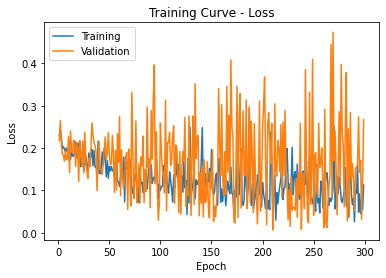

In [ ]:
plot_training_curve_loss(train_loss, val_loss)


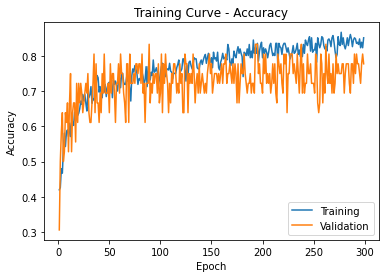

In [ ]:
plot_training_curve_accuracy(train_acc, val_acc)


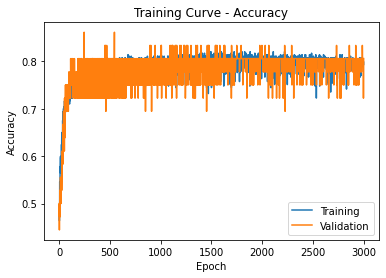

In [ ]:
plot_training_curve_accuracy(train_acc, val_acc)
#plot_training_curve_loss(train_loss, val_loss)

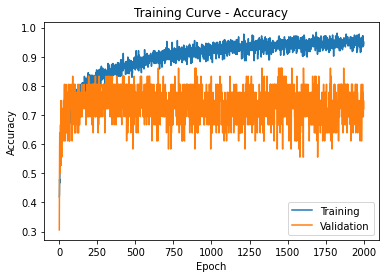

In [ ]:
plot_training_curve_accuracy(train_acc, val_acc)


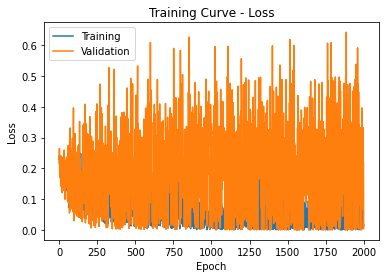

In [ ]:
plot_training_curve_loss(train_loss, val_loss)


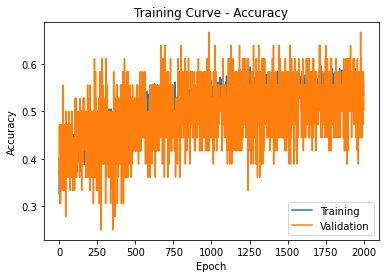

In [ ]:
plot_training_curve_accuracy(train_acc, val_acc)


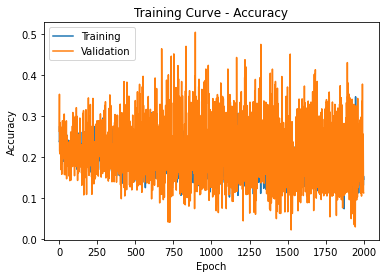

In [ ]:
plot_training_curve_loss(train_loss, val_loss)


### Sanity Check

In [ ]:
# SANITY CHECK: 300 Genes -> Multilayered -> ORDINAL

torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=True)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_acc, val_acc, train_loss, val_loss = train_net('ordinal', model, train_loader_i, test_loader_i, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.555205047318612 Validation Accuracy: 0.4722222222222222
20th Iteration.
Epoch: 100 Training Accuracy: 0.7697160883280757 Validation Accuracy: 0.7777777777777778
2020th Iteration.
Epoch: 200 Training Accuracy: 0.8264984227129337 Validation Accuracy: 0.7777777777777778
4020th Iteration.
Epoch: 300 Training Accuracy: 0.832807570977918 Validation Accuracy: 0.7222222222222222
6020th Iteration.
Epoch: 400 Training Accuracy: 0.8201892744479495 Validation Accuracy: 0.75
8020th Iteration.
Epoch: 500 Training Accuracy: 0.8548895899053628 Validation Accuracy: 0.6944444444444444
10020th Iteration.
Epoch: 600 Training Accuracy: 0.8990536277602523 Validation Accuracy: 0.75
12020th Iteration.
Epoch: 700 Training Accuracy: 0.9116719242902208 Validation Accuracy: 0.7777777777777778
14020th Iteration.
Epoch: 800 Training Accuracy: 0.943217665615142 Validation Accuracy: 0.75
16020th Iteration.
Epoch: 900 Training Accuracy: 0.9684542586

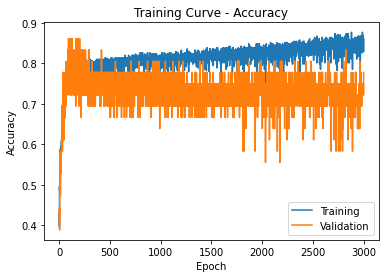

In [ ]:
# SANITY CHECK: 300 Genes -> Multilayered 
plot_training_curve_accuracy(train_acc, val_acc)

# 6. Prediction

In [ ]:
!cp /content/Checkpoint_Files/model_MulticlassANN_bs16_lr0.001_epoch295 /content

In [ ]:
def predict(net, model_path, sample):
    state = torch.load(model_path)
    net.load_state_dict(state)
    net.eval()
    x = torch.from_numpy(sample)
    print(x.float())
    output = net(x.float())
    return output

In [ ]:
net = MulticlassClassification_3(12, 3)
#model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=2444)
#model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=378)
#model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=1264)
model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=295)
predict(net, model_path, X_test_ohe[None, 32])

tensor([[2.6161, 2.5711, 2.6116, 3.1971, 2.9768, 2.4146, 2.5690, 2.9620, 3.1106,
         2.9738, 3.0232, 3.0042]])


tensor([[0.0432, 0.9047, 0.0521]], grad_fn=<SoftmaxBackward>)

In [ ]:
Y_test_ohe[32]

array([0., 1., 0.])

# 7. Weight Export

In [ ]:
%cd /content/

/content


In [ ]:
import json

genes = ['204439_at', '213797_at', '219519_s_at', '207329_at', '212768_s_at', '205569_at', '214059_at', '205844_at', '206177_s_at', '216191_s_at', '219669_at', '216834_at']
one_hot = {"non-infectious illness": [1, 0, 0], "bacterial": [0, 1, 0], "viral": [0, 0, 1]}
shape = [12, 24, 12, 3]

tables = ["NN_Shape", "Gene_List", "Weights", "One-Hot_Encoded_Output", "Biases"]
data = {}

lay1 = []
for i in range(0, len(w[0])):
    lay1.append(w[0][i].detach().tolist())

bias1 = []
for i in range(0, len(w[1])):
    bias1.append(w[1][i].detach().tolist())

lay2 = []
for i in range(0, len(w[2])):
    lay2.append(w[2][i].detach().tolist())

bias2 = []
for i in range(0, len(w[3])):
    bias2.append(w[3][i].detach().tolist())

lay3 = []
for i in range(0, len(w[4])):
    lay3.append(w[4][i].detach().tolist())

bias3 = []
for i in range(0, len(w[5])):
    bias3.append(w[5][i].detach().tolist())


for t in range(0, len(tables)):
    results = [shape, genes, [lay1, lay2, lay3], one_hot, [bias1, bias2, bias3]]
    data[tables[t]] = results[t]

with open("pytorch_model.json", "w+") as f:
    json.dump(data, f)

In [ ]:
w = list(net.parameters())

In [ ]:
w

[Parameter containing:
 tensor([[ 3.0080e-03, -2.3511e-01, -6.9227e-02,  1.2367e-01, -2.2938e-02,
           9.4622e-02,  1.0318e-01,  1.7699e-01,  2.6797e-02,  7.1172e-02,
           1.1609e-01,  2.5471e-01],
         [ 1.0219e-01, -1.1823e-01,  9.5408e-02, -1.5199e-01, -9.1411e-02,
          -3.1698e-02,  2.0240e-01,  2.7875e-02, -7.5092e-02,  9.5375e-02,
          -1.7730e-01, -9.9120e-02],
         [-3.4879e-02,  6.7539e-03, -2.7162e-02,  5.0782e-02, -2.0695e-01,
           1.2306e-01, -9.4309e-02,  5.9767e-02,  7.1626e-02, -3.3059e-01,
          -4.8589e-01, -1.9399e-01],
         [ 2.4652e-01, -2.9413e-02,  1.1647e-01, -1.0979e-01,  2.7121e-01,
          -1.6890e-01,  1.7835e-01,  7.6114e-02, -3.4680e-02,  2.5599e-01,
          -1.3901e-01,  7.6129e-02],
         [-4.8124e-02, -2.1730e-02, -3.0190e-01, -2.4850e-01,  1.4720e-01,
          -9.3602e-02,  2.1525e-01,  1.6672e-01, -5.8955e-03, -2.4858e-01,
           1.4995e-01, -4.9768e-02],
         [-1.6797e-01,  1.9635e-01,  2.323